# TC Simplified ECG Model
Example of using SymPy to explore mathematical formulas symbolically. TC implementation of a simplified ECG model.

In [1]:
# Load Extensions

# cpu line profiler
%load_ext line_profiler
# memory profiler
%load_ext memory_profiler
# Cython support
%load_ext Cython

# Reload modules before executing user code
%load_ext autoreload
%autoreload 2

# setup backend for matplotlibs plots
%matplotlib inline

In [2]:
# Imports
import pandas as pd
import numpy as np
from sympy import *
init_printing(use_unicode=True)
import matplotlib.pyplot as plt
import seaborn as sns
from sympy.plotting import plot
sns.set()

In [3]:
# create symbols for sympy processing
k,K_B,A_P,K_P,K_PQ,A_Q,K_Q,A_R,K_R,A_S,K_S,K_CS,s_m,A_T,K_T,K_ST,s_I,K_I= symbols('k K_B A_P K_P K_PQ A_Q K_Q A_R K_R A_S K_S K_CS s_m A_T K_T K_ST s_I K_I')

### Explore Research Paper Implementation
[MODEL FOR GENERATING SIMPLE SYNTHETIC ECG SIGNALS](https://www.researchgate.net/publication/328097407_MODEL_FOR_GENERATING_SIMPLE_SYNTHETIC_ECG_SIGNALS)

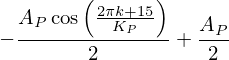

In [4]:
# P wave
P=-A_P/2*cos((2*pi*k + 15)/K_P)+A_P/2
P

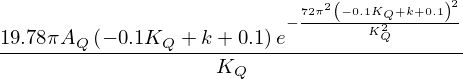

In [5]:
# Q wave
Q=A_Q*(k-0.1*K_Q+0.1)*(19.78*pi/K_Q)*exp(-2*(((6*pi)/K_Q)*(k-0.1*K_Q+0.1))**2)
Q

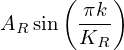

In [6]:
# R wave
R=A_R*sin(pi*k/K_R)
R

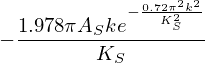

In [7]:
# S wave
S=-A_S*0.1*k*19.78*pi/K_S*exp(-2*(6*pi*0.1*k/K_S)**2)
S

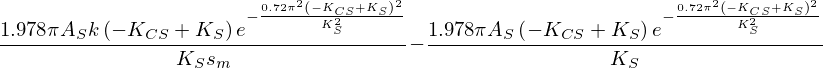

In [8]:
# S to T wave
S_T=-S.subs(k,(K_S-K_CS))*k/s_m+S.subs(k,(K_S-K_CS))
S_T

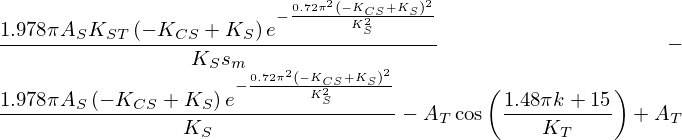

In [9]:
# T wave
T=-A_T*cos((1.48*pi*k+15)/K_T)+A_T+S_T.subs(k,K_ST)
T

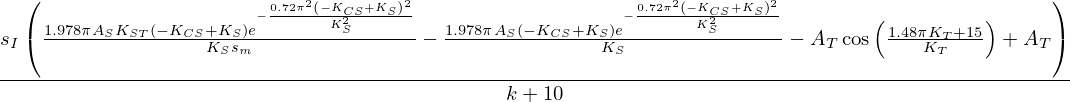

In [10]:
# T to I wave
I=T.subs(k,K_T)*s_I/(k+10)
I

### Visulize The waves for health ECG

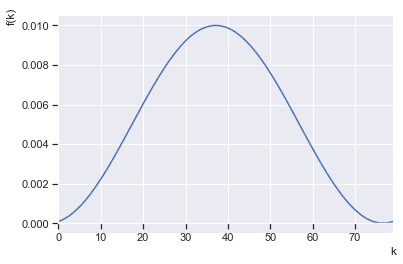

In [11]:
# P wave
I_K_B=124
V_A_P=0.01
I_K_P=79
P_SUB = P.subs([(A_P,V_A_P),(K_P,I_K_P)])
P_P = Piecewise((P_SUB, Interval(0, I_K_P).contains(k)), (0, True))
plot(P_P,(k,0,I_K_P))

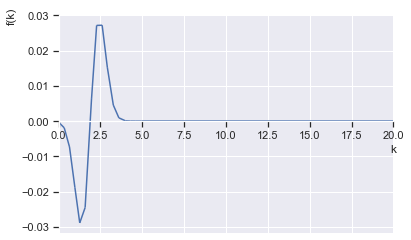

In [12]:
# Q wave
I_K_P_Q=5
I_K_Q=20
V_A_Q=0.03
Q_SUB=Q.subs([(A_Q,V_A_Q),(K_Q,I_K_Q)])
Q_P = Piecewise((Q_SUB,Interval(0, I_K_Q).contains(k)),(0,True))
plot(Q_P,(k,0,I_K_Q))

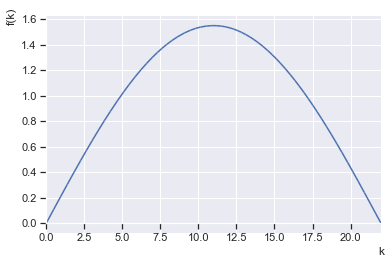

In [13]:
# R wave
V_A_R=1.55
I_K_R=22
R_SUB = R.subs([(A_R,V_A_R),(K_R,I_K_R)])
R_P = Piecewise((R_SUB,Interval(0, I_K_R).contains(k)),(0,True))
plot(R_P,(k,0,I_K_R))

## TC Simplified model

In [14]:
def createECGModel():
    p=0.1*sin((pi*k+120)/80)
    p_p=Piecewise((p,Interval(120,200).contains(k)),(0,True))
    q=-0.03*cos((pi*k-30)/20)
    q_p=Piecewise((q,Interval(240,260).contains(k)),(0,True))
    r=1.1*cos((pi*k+31.2)/20)
    r_p=Piecewise((r,Interval(260,280).contains(k)),(0,True))
    s=-0.06*sin(pi*k/10)
    s_p=Piecewise((s,Interval(280,290).contains(k)),(0,True))
    t=0.4*sin((pi*k-215)/110)
    t_p=Piecewise((t,Interval(290,400).contains(k)),(0,True))
    return p_p+q_p+r_p+s_p+t_p

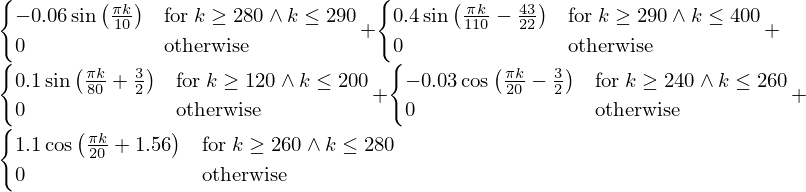

In [15]:
ecg = createECGModel()
ecg

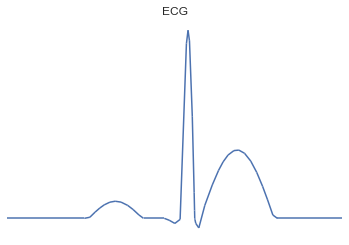

In [16]:
with sns.axes_style("white"):
    plot(ecg,(k,0,500),axis=False,title="ECG")        

In [30]:
def slowCreateECGSignal(ecg):
    # get one period
    period = np.arange(0,500)
    data = []
    
    for t in period:
        data.append(ecg.subs(k,t))
    
    df = pd.DataFrame(data,columns =['ecg'], dtype = float)

    # duplicate data - this is for visualization only
    df = df.append(df,ignore_index=True)
    df = df.append(df,ignore_index=True)
    df = df.append(df,ignore_index=True)

    return df

In [31]:
%lprun -f slowCreateECGSignal dfECG_slow = slowCreateECGSignal(ecg)

Timer unit: 1e-06 s

Total time: 4.03055 s
File: <ipython-input-30-72ecdcbb1a23>
Function: slowCreateECGSignal at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def slowCreateECGSignal(ecg):
     2                                               # get one period
     3         1         18.0     18.0      0.0      period = np.arange(0,500)
     4         1          1.0      1.0      0.0      data = []
     5                                               
     6       501       1240.0      2.5      0.0      for t in period:
     7       500    3805556.0   7611.1     94.4          data.append(ecg.subs(k,t))
     8                                               
     9         1     222566.0 222566.0      5.5      df = pd.DataFrame(data,columns =['ecg'], dtype = float)
    10                                           
    11                                               # duplicate data - this is for visualization only


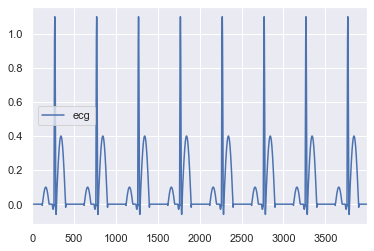

In [33]:
# Quick check
dfECG_slow.plot()

In [34]:
def createECGSignal(ecg):
    # vectorize sympy
    ecg_lam = lambdify(k,ecg,'numpy')

    # get one period
    period = np.arange(0,500)
    df = pd.DataFrame(data=ecg_lam(period))

    # duplicate data - this is for visualization only
    df = df.append(df,ignore_index=True)
    df = df.append(df,ignore_index=True)
    df = df.append(df,ignore_index=True)

    return df

In [35]:
%lprun -f createECGSignal dfECG = createECGSignal(ecg)

Timer unit: 1e-06 s

Total time: 0.025095 s
File: <ipython-input-34-6e3801824dd9>
Function: createECGSignal at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def createECGSignal(ecg):
     2                                               # vectorize sympy
     3         1      22236.0  22236.0     88.6      ecg_lam = lambdify(k,ecg,'numpy')
     4                                           
     5                                               # get one period
     6         1         13.0     13.0      0.1      period = np.arange(0,500)
     7         1       1230.0   1230.0      4.9      df = pd.DataFrame(data=ecg_lam(period))
     8                                           
     9                                               # duplicate data - this is for visualization only
    10         1        606.0    606.0      2.4      df = df.append(df,ignore_index=True)
    11         1        498.0    498.0      2.0   

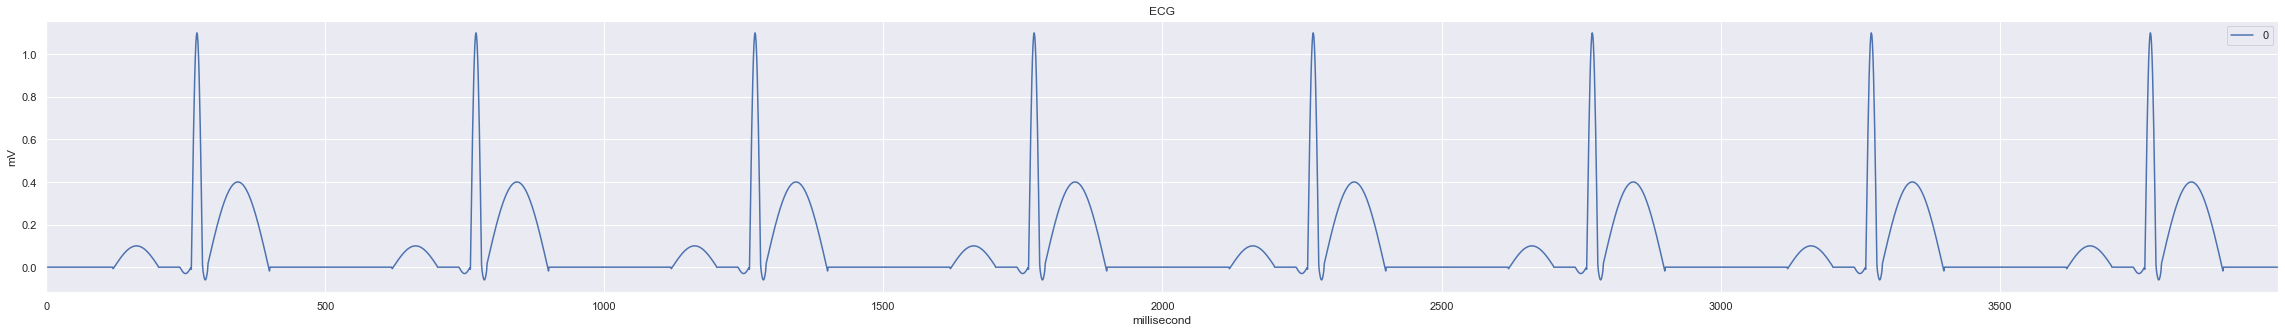

In [36]:
fig, ax = plt.subplots(figsize=(40, 5))
dfECG.plot(ax=ax,title="ECG")
ax.set_xlabel("millisecond")
ax.set_ylabel("mV")
plt.show()